# Data Project - Data Cleaning


## Library Import

In [75]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [76]:
import numpy as np
import pandas as pd
PREVIOUS_MAX_ROWS = pd.options.display.max_rows
pd.options.display.max_rows = 20
np.random.seed(12345)
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))
np.set_printoptions(precision=4, suppress=True)

import sklearn.linear_model as skl_lm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from sklearn.model_selection import RandomizedSearchCV




## Data Engineering

### Data Import - SCI Data


In [77]:
'''read SCI data'''
cc = pd.read_csv('county_county.tsv', sep='\t')

'''Merge Social connectedness pairs with dataset of distances. Pairs of the same codes are set to 0'''
distance = pd.read_csv('countydistancemiles.csv') #https://www.nber.org/research/data/county-distance-database
sci_dis = pd.merge(cc, distance, left_on=  ['user_loc', 'fr_loc'],
                   right_on= ['county1', 'county2'], 
                   how = 'left')
sci_dis.loc[ sci_dis['user_loc'] == sci_dis['fr_loc'], 'mi_to_county'] = 0

'''this drops counties that are outside of the landlocked domestic states where distance data is not available for.
In particular, this includes American Samoa, Northern Mariana Islands, Guam, MP, Virgin Islands'''

sci_dis.drop(sci_dis[sci_dis['fr_loc'].isin([2158, 46102, 60010,60020, 66010, 69100, 69110, 78010, 78020, 78030])].index, inplace = True)
sci_dis.drop(sci_dis[sci_dis['user_loc'].isin([2158, 46102, 60010,60020, 66010, 69100, 69110, 78010, 78020, 78030])].index, inplace = True)
sci_dis.drop('county1', axis=1, inplace=True)
sci_dis.drop('county2', axis=1, inplace=True)



'read SCI data'

'Merge Social connectedness pairs with dataset of distances. Pairs of the same codes are set to 0'

'this drops counties that are outside of the landlocked domestic states where distance data is not available for.\nIn particular, this includes American Samoa, Northern Mariana Islands, Guam, MP, Virgin Islands'

In [78]:
'''Sort pairings into buckets based on distance between counties: <50 miles, between 50-100 miles, 100-200 miles, and 200+ miles'''
cut_labels_4 = ['<50', '50-100', '100-200', '200+']
cut_bins = [-1, 50, 100, 200,1000000]
sci_dis['cut_ex1'] = pd.cut(sci_dis['mi_to_county'], bins=cut_bins, labels=cut_labels_4)

'''Use pivot table to aggregate number of friendships in each distance bucket per county'''
sci_dis_pivot = pd.pivot_table(sci_dis, values='scaled_sci', 
                                index='user_loc', 
                                columns='cut_ex1', 
                                aggfunc=sum).reset_index()

'''Calculate percentages of friendships in each bucket for a given county '''
sci_dis_pivot['total'] = sci_dis_pivot['<50'] + sci_dis_pivot['50-100'] + sci_dis_pivot['100-200'] + sci_dis_pivot['200+']
sci_dis_pivot['%<50'] = sci_dis_pivot['<50'] / sci_dis_pivot['total']
sci_dis_pivot['%50-100'] = sci_dis_pivot['50-100'] / sci_dis_pivot['total']
sci_dis_pivot['%100-200'] = sci_dis_pivot['100-200'] / sci_dis_pivot['total']
sci_dis_pivot['%200+'] = sci_dis_pivot['200+'] / sci_dis_pivot['total']

'Sort pairings into buckets based on distance between counties: <50 miles, between 50-100 miles, 100-200 miles, and 200+ miles'

'Use pivot table to aggregate number of friendships in each distance bucket per county'

'Calculate percentages of friendships in each bucket for a given county '

### Dependent Variable - election data


In [79]:
'''
data source for election data:
https://raw.githubusercontent.com/tonmcg/US_County_Level_Election_Results_08-20/f9b5f335ad1c66a7eba681539db49eec0c22787b/2020_US_County_Level_Presidential_Results.csv", "election.csv")
'''
from urllib.request import urlretrieve
urlretrieve("https://raw.githubusercontent.com/tonmcg/US_County_Level_Election_Results_08-20/f9b5f335ad1c66a7eba681539db49eec0c22787b/2020_US_County_Level_Presidential_Results.csv", "election.csv")
election = pd.read_csv('election.csv')


'\ndata source for election data:\nhttps://raw.githubusercontent.com/tonmcg/US_County_Level_Election_Results_08-20/f9b5f335ad1c66a7eba681539db49eec0c22787b/2020_US_County_Level_Presidential_Results.csv", "election.csv")\n'

('election.csv', <http.client.HTTPMessage at 0x7fb51ee087f0>)

In [80]:
'''data source for CVAP data. This is used as the denominator for calculating voter participation
https://www.census.gov/programs-surveys/decennial-census/about/voting-rights/cvap.html'''

cvap = pd.read_csv('County_CVAP.csv', encoding = "ISO-8859-1", usecols=[0, 1, 2, 4, 10])
cvap['fips'] = cvap['geoid'].str[-5:].astype(int)
cvap = cvap[cvap.lntitle == 'Total']
cvap = cvap[['fips', 'cvap_est', 'tot_est']]

'''Merged with election data to create master table.'''
master = pd.merge(sci_dis_pivot, election, left_on=  ['user_loc'], right_on= ['county_fips'], how = 'left')


'''Merged with cvap data to add to master table.'''
master = pd.merge(master, cvap, left_on=  ['user_loc'], right_on= ['fips'], how = 'left')

'''Dropped counties where election data is not available. These turned out to be a bunch in Alaska and Puerto Rico'''
master.dropna(inplace = True)

'''participation defined as total votes out of estimated voter population'''
master['participation'] = master['total_votes'] / master['cvap_est']

'data source for CVAP data. This is used as the denominator for calculating voter participation\nhttps://www.census.gov/programs-surveys/decennial-census/about/voting-rights/cvap.html'

'Merged with election data to create master table.'

'Merged with cvap data to add to master table.'

'Dropped counties where election data is not available. These turned out to be a bunch in Alaska and Puerto Rico'

'participation defined as total votes out of estimated voter population'

'I wanted to see how the outcome variable was distributed. Looks to be roughly bell shaped'

(array([   1.,   60.,  566., 1483.,  869.,  124.,    4.,    2.,    0.,
           2.]),
 array([0.1942, 0.3212, 0.4481, 0.5751, 0.702 , 0.829 , 0.956 , 1.0829,
        1.2099, 1.3368, 1.4638]),
 <BarContainer object of 10 artists>)

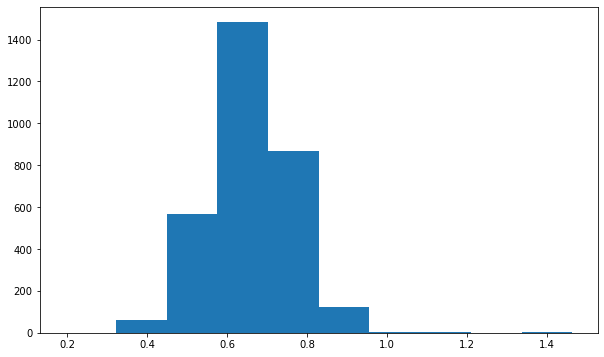

In [81]:

'''I wanted to see how the outcome variable was distributed. Looks to be roughly bell shaped'''
plt.hist(master['participation'])

### Demographic Data 

In [82]:
'''this imports and organizes Race and Gender data'''
demog = pd.read_csv('demographic.csv', encoding = "ISO-8859-1", usecols = [i for i in range(1, 22)])
demog = demog[demog.YEAR == 12]
demog = demog[demog.AGEGRP == 0]

demog['STATE'] = demog['STATE']*1000
demog['FIPS'] = demog['STATE'] + demog['COUNTY']
demog = demog.drop(demog.columns[1], axis = 1)
demog = demog.drop(demog.columns[0], axis = 1)

demog['%TOT_M'] = demog['TOT_MALE'] / demog['TOT_POP']
demog['%TOT_F'] = demog['TOT_FEMALE'] / demog['TOT_POP']
demog['%WA_M'] = demog['WA_MALE'] / demog['TOT_POP']
demog['%WA_F'] = demog['WA_FEMALE'] / demog['TOT_POP']
demog['%WA'] = (demog['WA_FEMALE'] + demog['WA_MALE']) / demog['TOT_POP']
demog['%BA_M'] = demog['BA_MALE'] / demog['TOT_POP']
demog['%BA_F'] = demog['BA_FEMALE'] / demog['TOT_POP']
demog['%BA'] = (demog['BA_FEMALE'] + demog['BA_MALE']) / demog['TOT_POP']
demog['%IA_M'] = demog['IA_MALE'] / demog['TOT_POP']
demog['%IA_F'] = demog['IA_FEMALE'] / demog['TOT_POP']
demog['%IA'] = (demog['IA_FEMALE'] + demog['IA_MALE']) / demog['TOT_POP']
demog['%AA_M'] = demog['AA_MALE'] / demog['TOT_POP']
demog['%AA_F'] = demog['AA_FEMALE'] / demog['TOT_POP']
demog['%AA'] = (demog['AA_FEMALE'] + demog['AA_MALE']) / demog['TOT_POP']
demog['%NA_M'] = demog['NA_MALE'] / demog['TOT_POP']
demog['%NA_F'] = demog['NA_FEMALE'] / demog['TOT_POP']
demog['%NA'] = (demog['NA_FEMALE'] + demog['NA_MALE']) / demog['TOT_POP']
demog['%TOM_M'] = demog['TOM_MALE'] / demog['TOT_POP']
demog['%TOM_F'] = demog['TOM_FEMALE'] / demog['TOT_POP']
demog['%TOM'] = (demog['TOM_FEMALE'] + demog['TOM_MALE']) / demog['TOT_POP']

cols = ['TOT_POP', 'STNAME', 'CTYNAME','YEAR', 'AGEGRP', 'TOT_MALE', 'TOT_FEMALE', 'WA_MALE', 'WA_FEMALE', 'BA_MALE', 'BA_FEMALE', 'IA_MALE', 'IA_FEMALE', 'AA_MALE', 'AA_FEMALE', 'NA_MALE', 'NA_FEMALE', 'TOM_MALE', 'TOM_FEMALE']
demog.drop(cols, axis = 1, inplace=True)

'''Merge demog with master to add race/gender to master table'''
master = pd.merge(master, demog, left_on=  ['user_loc'], right_on= ['FIPS'], how = 'left')


'this imports and organizes Race and Gender data'

'Merge demog with master to add race/gender to master table'

In [83]:
'''This imports and organizes education data'''
edu = pd.read_csv('education.csv', usecols = [0, 7, 8, 9, 10])
edu['%<high'] = edu['%<high']/100
edu['%high'] = edu['%high']/100
edu['%somecollege'] = edu['%somecollege']/100
edu['%bachelorplus'] = edu['%bachelorplus']/100


'''Merge edu with master to add edu to master table'''
master = pd.merge(master, edu, left_on=  ['user_loc'], right_on= ['FIPS Code'], how = 'left')


'This imports and organizes education data'

'Merge edu with master to add edu to master table'

In [84]:
'''this imports and organizes poverty rate data'''
pov = pd.read_csv('Poverty.csv')
pov['per_pov2019'] = pov['per_pov2019']/100


'''Merge pov with master to add poverty rates to master table'''
master = pd.merge(master, pov, left_on=  ['user_loc'], right_on= ['FIPStxt'], how = 'left')

'this imports and organizes poverty rate data'

'Merge pov with master to add poverty rates to master table'

In [85]:
'''Merge unemp with master to add unemployment rates/med income to master table'''

unemp = pd.read_csv('unemployment.csv').dropna()
unemp['unemployment2020'] = unemp['unemployment2020']/100

master = pd.merge(master, unemp, left_on=  ['user_loc'], right_on= ['FIPS_Code'], how = 'left')

'Merge unemp with master to add unemployment rates/med income to master table'

### Test / Train Split

In [86]:
'''this splits the data into training and testing data'''
y = master['participation'] 
x_train, x_test, y_train, y_test = train_test_split(master, y, test_size=0.1, random_state=52)


'this splits the data into training and testing data'

# Models

### OLS 

'a quick visual check to see if there is a linear relationship between explanatory and outcome variables '

/Users/emilyding/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


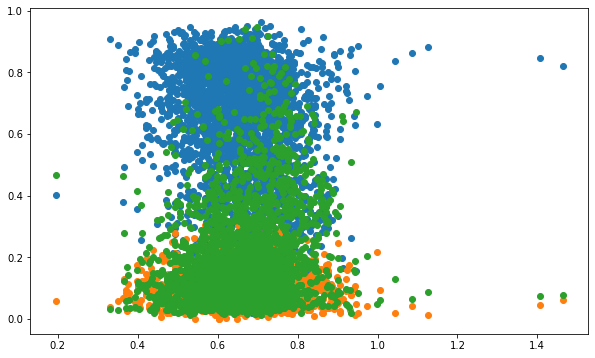

In [87]:
'''a quick visual check to see if there is a linear relationship between explanatory and outcome variables '''

# drop one bc of collinearity
x_train_sci = x_train[['%<50', '%50-100', '%200+']]
x_test_sci = x_test[['%<50', '%50-100', '%200+']]

#add a constant to introduce intercept
exog = sm.add_constant(x_train_sci)
exog_test = sm.add_constant (x_test_sci)

plt.scatter(y_train, exog['%<50'])
plt.scatter(y_train, exog['%50-100'])
plt.scatter(y_train, exog['%200+'])

In [88]:
'''a first model to see if SCI has any predictive power towards vote participation'''


#run OLS on SCI predictors
est = sm.OLS(y_train, exog).fit()
print(est.summary())
print(np.sqrt(mean_squared_error(y_test, est.predict(exog_test))))

#add RMSE to result table
rmse_results = {"OLS w/ 3 SCI buckets": np.sqrt(mean_squared_error(y_test, est.predict(exog_test)))}


'a first model to see if SCI has any predictive power towards vote participation'

                            OLS Regression Results                            
Dep. Variable:          participation   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     45.39
Date:                Wed, 01 Jun 2022   Prob (F-statistic):           1.23e-28
Time:                        00:05:00   Log-Likelihood:                 2470.3
No. Observations:                2799   AIC:                            -4933.
Df Residuals:                    2795   BIC:                            -4909.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8388      0.067     12.443      0.0

In [89]:
'''Since one of the buckets is not significant, rerun OLS on sci predictors to see if they have predictive power towards vote participation'''
x_train_sci2 = x_train[['%<50', '%50-100']]
x_test_sci2 = x_test[['%<50', '%50-100']]

#add constant
exog2 = sm.add_constant(x_train_sci2)
exog2_test = sm.add_constant (x_test_sci2)

#run OLS on formula predictors
est2 = sm.OLS(y_train, exog2).fit()
print(est2.summary())
print(np.sqrt(mean_squared_error(y_test, est2.predict(exog2_test))))

rmse_results["OLS with 2 distance buckets"] = np.sqrt(mean_squared_error(y_test, est2.predict(exog2_test)))


'Since one of the buckets is not significant, rerun OLS on sci predictors to see if they have predictive power towards vote participation'

                            OLS Regression Results                            
Dep. Variable:          participation   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     67.14
Date:                Wed, 01 Jun 2022   Prob (F-statistic):           3.32e-29
Time:                        00:05:01   Log-Likelihood:                 2469.3
No. Observations:                2799   AIC:                            -4933.
Df Residuals:                    2796   BIC:                            -4915.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7480      0.010     77.413      0.0

/Users/emilyding/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [90]:
'''Took a look at VIF to see how bad of a multi-colinearity problem we have on the SCI buckets. They look okay.
'''

# referenced https://stackoverflow.com/questions/42658379/variance-inflation-factor-in-python for VIF functions
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = x_train_sci.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(x_train_sci.values, i) for i in range(len(x_train_sci.columns))]
print(vif_data)

'Took a look at VIF to see how bad of a multi-colinearity problem we have on the SCI buckets. They look okay.\n'

   feature       VIF
0     %<50  2.648042
1  %50-100  3.551469
2    %200+  1.934218


### Including Demographic Factors

In [91]:
'''This model uses all the demographic factors to run OLS to gauge a benchmark R squared value'''
'''remove %200+ '%TOT_M' '%<high'  '%TOM to prevent collinearity for categories that add up to 1'''

x_train_demog = x_train[['%<50', '%100-200' ,'%200+', '%WA','%BA','%IA','%AA','%NA', '%high','%somecollege','%bachelorplus',
                       '%TOT_F', 'med_income2019' ]]
x_test_demog= x_test[[ '%<50', '%100-200', '%200+', '%WA','%BA','%IA','%AA','%NA', '%high','%somecollege','%bachelorplus',
                       '%TOT_F', 'med_income2019' ]]

#add constant           
exogd = sm.add_constant(x_train_demog)
exogd_test = sm.add_constant (x_test_demog)
           

#run OLS on all predictors
est_demog = sm.OLS(y_train, exogd).fit()
print(est_demog.summary())
print(np.sqrt(mean_squared_error(y_test, est_demog.predict(exogd_test))))

rmse_results["OLS with all demog predictors"] = np.sqrt(mean_squared_error(y_test, est_demog.predict(exogd_test)))


'This model uses all the demographic factors to run OLS to gauge a benchmark R squared value'

"remove %200+ '%TOT_M' '%<high'  '%TOM to prevent collinearity for categories that add up to 1"

                            OLS Regression Results                            
Dep. Variable:          participation   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     199.6
Date:                Wed, 01 Jun 2022   Prob (F-statistic):               0.00
Time:                        00:05:01   Log-Likelihood:                 3325.2
No. Observations:                2799   AIC:                            -6622.
Df Residuals:                    2785   BIC:                            -6539.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.4239      0.161     -8.

/Users/emilyding/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [92]:
'''examine VIF - shows how multicollinearity. need to do feature selection'''
# referenced https://stackoverflow.com/questions/42658379/variance-inflation-factor-in-python for VIF functions
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = x_train_demog.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(x_train_demog.values, i) for i in range(len(x_train_demog.columns))]
print(vif_data)

'examine VIF - shows how multicollinearity. need to do feature selection'

           feature          VIF
0             %<50   395.021021
1         %100-200    27.323795
2            %200+    48.069550
3              %WA  1059.641659
4              %BA    43.038194
5              %IA     8.953626
6              %AA     4.397983
7              %NA     1.789539
8            %high    88.308340
9     %somecollege    56.699214
10   %bachelorplus    29.651223
11          %TOT_F   526.591778
12  med_income2019    41.562554


### Selecting With Forward Step

In [93]:
#declare variables again
x_train_demog = x_train[['%<50', '%100-200', '%200+', '%WA','%BA','%IA','%AA','%NA', '%high','%somecollege','%bachelorplus',
                       '%TOT_F', 'med_income2019' ]]

                       
x_test_demog= x_test[[ '%<50', '%100-200', '%200+', '%WA','%BA','%IA','%AA','%NA', '%high','%somecollege','%bachelorplus',
                       '%TOT_F', 'med_income2019' ]]



In [94]:

'''do forward selection to select the best predictors'''
# code is from class notes
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y_train, exogd[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(exogd[list(feature_set)]) - y_train) ** 2).sum()
    return {"model":regr, "RSS":RSS}

def forward(predictors):
    # Pull out predictors we still need to process
    remaining_predictors = [p for p in exogd.columns if p not in predictors]
    results = []
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    # Choose the model with the lowest RSS
    best_model = models.loc[models['RSS'].argmin()]
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors.")
    # Return the best model
    return best_model

models2 = pd.DataFrame(columns=["RSS", "model"])
predictors = []
for i in range(1,len(exogd.columns)+1):
    models2.loc[i] = forward(predictors)
    predictors = models2.loc[i]["model"].model.exog_names  
models2

'''examine the rsquared values of each model to see when an additional predictor does not benefit model fit '''
for i in range(len(models2)): 
    print('model ', i+1, ": ", models2.iloc[i]['model'].rsquared)

'do forward selection to select the best predictors'

Processed  14 models on 1 predictors.
Processed  13 models on 2 predictors.
Processed  12 models on 3 predictors.
Processed  11 models on 4 predictors.
Processed  10 models on 5 predictors.
Processed  9 models on 6 predictors.
Processed  8 models on 7 predictors.
Processed  7 models on 8 predictors.
Processed  6 models on 9 predictors.
Processed  5 models on 10 predictors.
Processed  4 models on 11 predictors.
Processed  3 models on 12 predictors.
Processed  2 models on 13 predictors.
Processed  1 models on 14 predictors.


,RSS,model
1,28.356864,<statsmodels.regression.linear_model.Regressio...
2,20.512976,<statsmodels.regression.linear_model.Regressio...
3,18.949701,<statsmodels.regression.linear_model.Regressio...
4,18.358882,<statsmodels.regression.linear_model.Regressio...
5,17.234542,<statsmodels.regression.linear_model.Regressio...
6,16.247949,<statsmodels.regression.linear_model.Regressio...
7,16.050836,<statsmodels.regression.linear_model.Regressio...
8,15.855686,<statsmodels.regression.linear_model.Regressio...
9,15.672917,<statsmodels.regression.linear_model.Regressio...
10,15.585092,<statsmodels.regression.linear_model.Regressio...


'examine the rsquared values of each model to see when an additional predictor does not benefit model fit '

model  1 :  0.977069737965204
model  2 :  0.9834125552206474
model  3 :  0.9846766690395757
model  4 :  0.9851544242899757
model  5 :  0.9860636006884081
model  6 :  0.9868613914764149
model  7 :  0.9870207830725288
model  8 :  0.9871785876662434
model  9 :  0.4672302123870026
model  10 :  0.4702156427586611
model  11 :  0.472290539878259
model  12 :  0.47747719311444425
model  13 :  0.4816672301360133
model  14 :  0.48234627442903755


In [95]:
'''the model with 8 predictors performs the best - Run an OLS with these predictors'''
A = dict(models2.loc[8, "model"].params).keys()
print(A)

model_train_X = pd.DataFrame()
model_test_X = pd.DataFrame()

for k in A:
    model_train_X[str(k)+"_added"] = x_train_demog[k]
    model_test_X[str(k)+"_added"] = x_test_demog[k]
    
model_train_X = sm.add_constant(model_train_X)
model_test_X = sm.add_constant (model_test_X)
model_train_X.head()
model_stepwise = sm.OLS(y_train, model_train_X).fit()
model_stepwise.summary()
print(np.sqrt(mean_squared_error(y_test, model_stepwise.predict(model_test_X))))

rmse_results["Forward Stepwise w/ 8 predictors"] = np.sqrt(mean_squared_error(y_test, model_stepwise.predict(model_test_X)))



'the model with 8 predictors performs the best - Run an OLS with these predictors'

dict_keys(['%TOT_F', 'med_income2019', '%somecollege', '%100-200', '%bachelorplus', '%AA', '%IA', '%high'])


/Users/emilyding/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,const,%TOT_F_added,med_income2019_added,%somecollege_added,%100-200_added,%bachelorplus_added,%AA_added,%IA_added,%high_added
1281,1.0,0.504378,76728.0,0.247,0.136551,0.559,0.093767,0.003906,0.146
1298,1.0,0.491495,54896.0,0.342,0.059206,0.171,0.003175,0.094579,0.349
1323,1.0,0.494721,75519.0,0.351,0.093684,0.230,0.006820,0.005435,0.358
2738,1.0,0.498101,76905.0,0.297,0.121089,0.218,0.006540,0.009771,0.361
1354,1.0,0.487227,95323.0,0.395,0.184574,0.266,0.012639,0.005882,0.285


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          participation   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     305.8
Date:                Wed, 01 Jun 2022   Prob (F-statistic):               0.00
Time:                        00:05:01   Log-Likelihood:                 3284.9
No. Observations:                2799   AIC:                            -6552.
Df Residuals:                    2790   BIC:                            -6498.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.2259      0.040     -5.704      0.000      -0.304      -0.148
%TOT_F_added             0.6764      0.065     10.367      0.000       0.548       0.804
med_income2019_added  2.788e-06   1.51e-07     18.501      0.000    2.49e-06    3.08e-06
%somecollege_added       0.7003      0.033     21.027      0.000       0.635       0.766
%100-200_added          -0.5090      0.040    -12.847      0.000      -0.587      -0.431
%bachelorplus_added      0.5662      0.032     17.589      0.000       0.503       0.629
%AA_added               -0.7098      0.067    -10.640      0.000      -0.841      -0.579
%IA_added               -0.1238      0.022     -5.667      0.000      -0.167      -0.081
%high_added              0.2976      0.037      7.995      0.000       0.225       0.371
==============================================================================
Omnibus:                      867.991   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11266.180
Skew:                           1.096   Prob(JB):                         0.00
Kurtosis:                      12.581   Cond. No.                     2.99e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.99e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

0.06996915351642546


In [96]:
'''examine the VIF of '''
pred = ['%TOT_F', 'med_income2019', '%somecollege', '%100-200', '%bachelorplus', '%AA', '%IA', '%high']

training_X_new = x_train_demog[pred].copy()

vif_data_new = pd.DataFrame()
vif_data_new["feature"] = ['%TOT_F', 'med_income2019', '%somecollege', '%100-200', '%bachelorplus', '%AA', '%IA', '%high']
vif_data_new["VIF"] = [variance_inflation_factor(training_X_new.values, i) for i in range(len(training_X_new.columns))]
print(vif_data_new)


'examine the VIF of '

          feature         VIF
0          %TOT_F  191.593663
1  med_income2019   36.764860
2    %somecollege   45.156398
3        %100-200    5.840018
4   %bachelorplus   28.075755
5             %AA    2.086409
6             %IA    1.173976
7           %high   61.689590


In [97]:

'''Redo the same process but without the SCI predictors to see how much of an impact the SCI predictors have'''
x_train_demog = x_train[[ '%WA','%BA','%IA','%AA','%NA', '%high','%somecollege','%bachelorplus',
                       '%TOT_F', 'med_income2019' ]]

                       
x_test_demog= x_test[[ '%WA','%BA','%IA','%AA','%NA', '%high','%somecollege','%bachelorplus',
                       '%TOT_F', 'med_income2019' ]]

# code is from class notes
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y_train, x_train_demog[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(x_train_demog[list(feature_set)]) - y_train) ** 2).sum()
    return {"model":regr, "RSS":RSS}

def forward(predictors):
    # Pull out predictors we still need to process
    remaining_predictors = [p for p in x_train_demog.columns if p not in predictors]
    results = []
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    # Choose the model with the lowest RSS
    best_model = models.loc[models['RSS'].argmin()]
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors.")
    # Return the best model
    return best_model

models2 = pd.DataFrame(columns=["RSS", "model"])
predictors = []
for i in range(1,len(x_train_demog.columns)+1):
    models2.loc[i] = forward(predictors)
    predictors = models2.loc[i]["model"].model.exog_names  
models2

for i in range(len(models2)): 
    print('model ', i+1, ": ", models2.iloc[i]['model'].rsquared)
    
    
A = dict(models2.loc[7, "model"].params).keys()
print(A)

model_train_X = pd.DataFrame()
model_test_X = pd.DataFrame()

           

for k in A:
    model_train_X[str(k)+"_added"] = x_train_demog[k]
    model_test_X[str(k)+"_added"] = x_test_demog[k]
    
model_train_X = sm.add_constant(model_train_X)
model_test_X = sm.add_constant (model_test_X)
model_train_X.head()
model_stepwise = sm.OLS(y_train, model_train_X).fit()
model_stepwise.summary()
print(np.sqrt(mean_squared_error(y_test, model_stepwise.predict(model_test_X))))

rmse_results["Forward Stepwise w/ 7 predictors without SCI"] = np.sqrt(mean_squared_error(y_test, model_stepwise.predict(model_test_X)))


'Redo the same process but without the SCI predictors to see how much of an impact the SCI predictors have'

Processed  10 models on 1 predictors.
Processed  9 models on 2 predictors.
Processed  8 models on 3 predictors.
Processed  7 models on 4 predictors.
Processed  6 models on 5 predictors.
Processed  5 models on 6 predictors.
Processed  4 models on 7 predictors.
Processed  3 models on 8 predictors.
Processed  2 models on 9 predictors.
Processed  1 models on 10 predictors.


,RSS,model
1,28.356864,<statsmodels.regression.linear_model.Regressio...
2,20.512976,<statsmodels.regression.linear_model.Regressio...
3,18.949701,<statsmodels.regression.linear_model.Regressio...
4,18.394520,<statsmodels.regression.linear_model.Regressio...
5,17.522625,<statsmodels.regression.linear_model.Regressio...
6,17.128130,<statsmodels.regression.linear_model.Regressio...
7,16.810995,<statsmodels.regression.linear_model.Regressio...
8,16.754223,<statsmodels.regression.linear_model.Regressio...
9,16.696658,<statsmodels.regression.linear_model.Regressio...
10,16.678450,<statsmodels.regression.linear_model.Regressio...


model  1 :  0.977069737965204
model  2 :  0.9834125552206474
model  3 :  0.9846766690395757
model  4 :  0.985125606252603
model  5 :  0.985830647795745
model  6 :  0.9861496494565766
model  7 :  0.9864060947476415
model  8 :  0.9864520021551191
model  9 :  0.9864985510559972
model  10 :  0.9865132744549507
dict_keys(['%TOT_F', 'med_income2019', '%somecollege', '%bachelorplus', '%AA', '%IA', '%high'])


/Users/emilyding/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,const,%TOT_F_added,med_income2019_added,%somecollege_added,%bachelorplus_added,%AA_added,%IA_added,%high_added
1281,1.0,0.504378,76728.0,0.247,0.559,0.093767,0.003906,0.146
1298,1.0,0.491495,54896.0,0.342,0.171,0.003175,0.094579,0.349
1323,1.0,0.494721,75519.0,0.351,0.230,0.006820,0.005435,0.358
2738,1.0,0.498101,76905.0,0.297,0.218,0.006540,0.009771,0.361
1354,1.0,0.487227,95323.0,0.395,0.266,0.012639,0.005882,0.285


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          participation   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                     307.9
Date:                Wed, 01 Jun 2022   Prob (F-statistic):               0.00
Time:                        00:05:02   Log-Likelihood:                 3204.5
No. Observations:                2799   AIC:                            -6393.
Df Residuals:                    2791   BIC:                            -6345.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.2425      0.041     -5.954      0.000      -0.322      -0.163
%TOT_F_added             0.6904      0.067     10.285      0.000       0.559       0.822
med_income2019_added  2.561e-06   1.54e-07     16.629      0.000    2.26e-06    2.86e-06
%somecollege_added       0.6317      0.034     18.674      0.000       0.565       0.698
%bachelorplus_added      0.5007      0.033     15.309      0.000       0.437       0.565
%AA_added               -0.6341      0.068     -9.274      0.000      -0.768      -0.500
%IA_added               -0.1704      0.022     -7.685      0.000      -0.214      -0.127
%high_added              0.3548      0.038      9.329      0.000       0.280       0.429
==============================================================================
Omnibus:                      864.965   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11487.123
Skew:                           1.084   Prob(JB):                         0.00
Kurtosis:                      12.685   Cond. No.                     2.99e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.99e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

0.07080617020376986


### Lasso Regression

In [98]:
x_train_demog = x_train[['%<50', '%100-200' ,'%200+', '%WA','%BA','%IA','%AA','%NA', '%high','%somecollege','%bachelorplus',
                       '%TOT_F', 'med_income2019' ]]

                       
x_test_demog= x_test[[ '%<50', '%100-200', '%200+', '%WA','%BA','%IA','%AA','%NA', '%high','%somecollege','%bachelorplus',
                       '%TOT_F', 'med_income2019' ]]

In [99]:
'''use lasso function to select predictors'''
def lasso(X_train, X_test, y_train, y_test):
    #define alpha
    scaler = StandardScaler().fit(X_train)
    alphas = 10**np.linspace(10,-2,100)
    # run lasso regression
    lassocv = skl_lm.LassoCV(alphas = alphas, max_iter=10000)
    lassocv.fit(scaler.fit_transform(X_train), y_train.values.ravel())
    lasso = skl_lm.Lasso()
    lasso.set_params(alpha = lassocv.alpha_)
    lasso.fit(scaler.fit_transform(X_train), y_train.values.ravel())
    print("RMSE", np.sqrt(mean_squared_error(y_test, lasso.predict(scaler.transform(X_test)))))
    rmse_results["Lasso Regression"] = np.sqrt(mean_squared_error(y_test, model_stepwise.predict(model_test_X)))

    #updating view settings to see full results
    pd.options.display.max_rows = 4000
    
    #predictors
    pred = dict(pd.Series(lasso.coef_.flatten(), index = X_train.columns))
    
    #find remaining predictors that have not been zeroed
    pred_sparse = []
    for k in pred:
        if pred[k] > 0.00000001:
            pred_sparse.append(k)
    print(pred_sparse)

    #new set of predictors
    lasso_training_X_new = X_train[pred_sparse].copy()
    lasso_testing_X_new = X_test[pred_sparse].copy()
    
     #display VIF for new predictors
    vif_data_new = pd.DataFrame()
    vif_data_new["feature"] = lasso_training_X_new.columns
    vif_data_new["VIF"] = [variance_inflation_factor(lasso_training_X_new.values, i) for i in range(len(lasso_testing_X_new.columns))]
    print(vif_data_new)
    return(lasso_training_X_new, lasso_testing_X_new)


(X_train_lasso, X_test_lasso) = lasso(x_train_demog, x_test_demog, y_train, y_test)

'''lasso regression does not select for SCI predictors'''

'use lasso function to select predictors'

RMSE 0.0754318598222907
['%WA', '%somecollege', '%bachelorplus', '%TOT_F', 'med_income2019']
          feature        VIF
0             %WA  29.956195
1    %somecollege  36.696791
2   %bachelorplus  13.637722
3          %TOT_F  55.028176
4  med_income2019  34.375875


'lasso regression does not select for SCI predictors'

### GLM models with percent participation

In [100]:
x_train_demog = x_train[['%<50', '%100-200' ,'%200+', '%WA','%BA','%IA','%AA','%NA', '%high','%somecollege','%bachelorplus',
                       '%TOT_F', 'med_income2019' ]]

                       
x_test_demog= x_test[[ '%<50', '%100-200', '%200+', '%WA','%BA','%IA','%AA','%NA', '%high','%somecollege','%bachelorplus',
                       '%TOT_F', 'med_income2019' ]]

In [101]:
exogd = sm.add_constant(x_train_demog)
exogd_test = sm.add_constant (x_test_demog)
           

glm_binom = sm.GLM(y_train, exogd, family=sm.families.Binomial())
res = glm_binom.fit()
print(res.summary())

print(np.sqrt(mean_squared_error(y_test, res.predict(exogd_test))))
rmse_results["GLM"] = np.sqrt(mean_squared_error(y_test, res.predict(exogd_test)))



                 Generalized Linear Model Regression Results                  
Dep. Variable:          participation   No. Observations:                 2799
Model:                            GLM   Df Residuals:                     2785
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1185.1
Date:                Wed, 01 Jun 2022   Deviance:                       153.40
Time:                        00:05:02   Pearson chi2:                     70.0
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -8.3489      4.519     -1.

/Users/emilyding/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [122]:
x_train_demog = x_train[['%WA','%BA','%IA','%AA','%NA', '%high','%somecollege','%bachelorplus',
                       '%TOT_F', 'med_income2019' ]]

                       
x_test_demog= x_test[[ '%WA','%BA','%IA','%AA','%NA', '%high','%somecollege','%bachelorplus',
                       '%TOT_F', 'med_income2019' ]]

exogd = sm.add_constant(x_train_demog)
exogd_test = sm.add_constant (x_test_demog)
           

glm_binom = sm.GLM(y_train, exogd, family=sm.families.Binomial())
res = glm_binom.fit()
print(res.summary())

print(np.sqrt(mean_squared_error(y_test, res.predict(exogd_test))))

rmse_results['GLM without SCI'] = np.sqrt(mean_squared_error(y_test, res.predict(exogd_test)))

                 Generalized Linear Model Regression Results                  
Dep. Variable:          participation   No. Observations:                 2799
Model:                            GLM   Df Residuals:                     2788
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1187.5
Date:                Wed, 01 Jun 2022   Deviance:                       157.93
Time:                        00:29:48   Pearson chi2:                     74.2
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -8.3983      4.280     -1.

/Users/emilyding/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [103]:
'''Attempted to run forward selection on GLM'''
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    model = sm.GLM(y_train, x_train_demog[list(feature_set)], family=sm.families.Binomial())
    regr = model.fit()
    RSS = ((regr.predict(x_train_demog[list(feature_set)]) - y_train) ** 2).sum()
    return {"model":regr, "RSS":RSS}

def forward(predictors):
    # Pull out predictors we still need to process
    remaining_predictors = [p for p in x_train_demog.columns if p not in predictors]
    results = []
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    # Choose the model with the lowest RSS
    best_model = models.loc[models['RSS'].argmin()]
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors.")
    # Return the best model
    return best_model

'Attempted to run forward selection on GLM'

In [104]:
models_GLM = pd.DataFrame(columns=["RSS", "model"])
predictors = []
for i in range(1,len(x_train_demog.columns)+1):
    models_GLM.loc[i] = forward(predictors)
    predictors = models_GLM.loc[i]["model"].model.exog_names  
models_GLM

Processed  10 models on 1 predictors.
Processed  9 models on 2 predictors.
Processed  8 models on 3 predictors.
Processed  7 models on 4 predictors.
Processed  6 models on 5 predictors.
Processed  5 models on 6 predictors.
Processed  4 models on 7 predictors.
Processed  3 models on 8 predictors.
Processed  2 models on 9 predictors.
Processed  1 models on 10 predictors.


,RSS,model
1,22.161509,<statsmodels.genmod.generalized_linear_model.G...
2,21.185066,<statsmodels.genmod.generalized_linear_model.G...
3,20.240249,<statsmodels.genmod.generalized_linear_model.G...
4,19.741600,<statsmodels.genmod.generalized_linear_model.G...
5,19.449962,<statsmodels.genmod.generalized_linear_model.G...
6,19.038875,<statsmodels.genmod.generalized_linear_model.G...
7,18.758300,<statsmodels.genmod.generalized_linear_model.G...
8,18.687328,<statsmodels.genmod.generalized_linear_model.G...
9,17.410319,<statsmodels.genmod.generalized_linear_model.G...
10,17.282701,<statsmodels.genmod.generalized_linear_model.G...


In [105]:
for i in range(1,len(x_train_demog.columns)+1):

    A = dict(models_GLM.loc[i, "model"].params).keys()
    print(A)

    model_train_X = pd.DataFrame()
    model_test_X = pd.DataFrame()

            

    for k in A:
        model_train_X[str(k)+"_added"] = x_train_demog[k]
        model_test_X[str(k)+"_added"] = x_test_demog[k]
        
    model_train_X = sm.add_constant(model_train_X)
    model_test_X = sm.add_constant (model_test_X)
    model_stepwise = sm.GLM(y_train, model_train_X, family=sm.families.Binomial())
    res = model_stepwise.fit()
    print(res.summary())
    print("model:", i, "RMSE:", np.sqrt(mean_squared_error(y_test, res.predict(model_test_X))))

#rmse_results["Forward Stepwise w/ 7 predictors"] = np.sqrt(mean_squared_error(y_test, model_stepwise.predict(model_test_X)))

dict_keys(['med_income2019'])
                 Generalized Linear Model Regression Results                  
Dep. Variable:          participation   No. Observations:                 2799
Model:                            GLM   Df Residuals:                     2797
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1198.6
Date:                Wed, 01 Jun 2022   Deviance:                       179.96
Time:                        00:05:03   Pearson chi2:                     95.5
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
co

/Users/emilyding/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/emilyding/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/emilyding/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/emilyding/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/emilyding/opt/ana

                 Generalized Linear Model Regression Results                  
Dep. Variable:          participation   No. Observations:                 2799
Model:                            GLM   Df Residuals:                     2788
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1187.5
Date:                Wed, 01 Jun 2022   Deviance:                       157.93
Time:                        00:05:03   Pearson chi2:                     74.2
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -8.3983 

/Users/emilyding/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


### XGBoost

In [125]:
'''Use XGBoost model '''

#needed to convert name to not use '<' symbol
x_train['%under50'] = x_train['%<50']
x_test['%under50'] = x_test['%<50']

x_train_demog = x_train[['%under50', '%100-200' ,'%200+', '%WA','%BA','%IA','%AA','%NA', '%high','%somecollege','%bachelorplus',
                       '%TOT_F', 'med_income2019' ]]

                       
x_test_demog= x_test[[ '%under50', '%100-200', '%200+', '%WA','%BA','%IA','%AA','%NA', '%high','%somecollege','%bachelorplus',
                       '%TOT_F', 'med_income2019' ]]

'Use XGBoost model '

/var/folders/np/wd22bbys3879bs9hw8g47xm00000gn/T/ipykernel_36604/3578819861.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['%under50'] = x_train['%<50']
/var/folders/np/wd22bbys3879bs9hw8g47xm00000gn/T/ipykernel_36604/3578819861.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['%under50'] = x_test['%<50']


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

0.003659560091937748


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

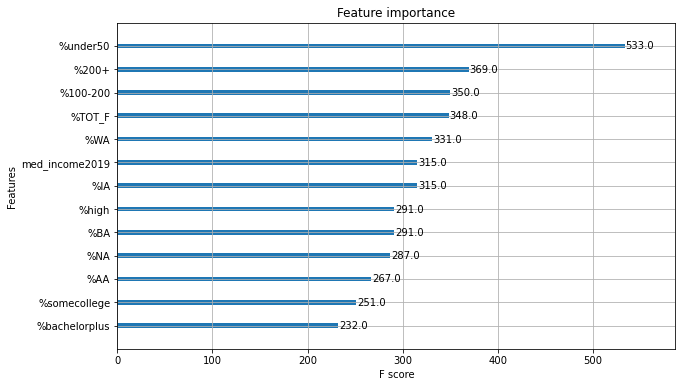

In [126]:

model = XGBRegressor()
model.fit(x_train_demog, y_train)
print(mean_squared_error(y_test, model.predict(x_test_demog)))

import matplotlib.pylab as plt
from matplotlib import pyplot
from xgboost import plot_importance
plot_importance(model) 
plt.show()


In [117]:


model = XGBRegressor()
parameters = {'tree_method' : ['auto', 'exact', 'approx', 'hist' ],
                'eta': sp_randFloat(0.01, 0.3),
                  'subsample'    : sp_randFloat(),
                  'n_estimators' : sp_randInt(100, 1000),
                  'max_depth'    : sp_randInt(4, 10)
                 }

randm_src = RandomizedSearchCV(estimator=model, param_distributions = parameters,
                               cv = 2, n_iter = 200, n_jobs=-1)
randm_src.fit(x_train_demog, y_train)

print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", randm_src.best_estimator_)
print("\n The best score across ALL searched params:\n", randm_src.best_score_)
print("\n The best parameters across ALL searched params:\n", randm_src.best_params_)

RandomizedSearchCV(cv=2,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          m...
                   param_distributions={'eta': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f

 Results from Random Search 

 The best estimator across ALL searched params:
 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.011280655395690843, eval_metric=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.0112806559,
             max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=5,
             max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=853, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0, ...)

 The best score across ALL searched params:
 0.5624237092814839

 The best parameters across ALL searched params:
 {'eta': 0.011280655395690843, 'max_depth': 5, 'n_estimators': 853, 'subsample': 0.4428923644744488, 'tr

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.011280655395690843, eval_metric=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.0112806559,
             max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=5,
             max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=853, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0, ...)

0.055750325457463855


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

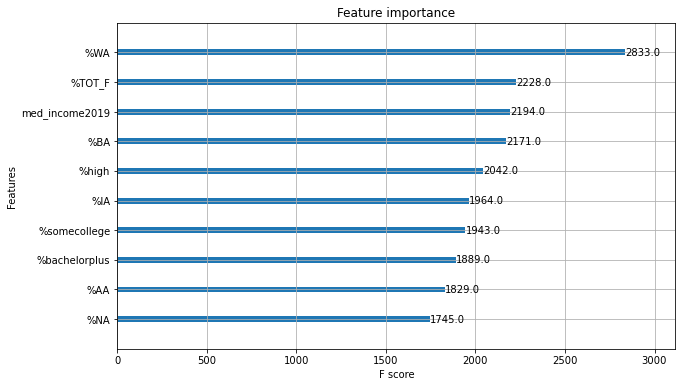

In [118]:
from xgboost import XGBRegressor

model = XGBRegressor(eta = 0.011280655395690843, max_depth = 5, n_estimators= 853, subsample = 0.4428923644744488, tree_method = 'hist')
model.fit(x_train_demog, y_train)
print(np.sqrt(mean_squared_error(y_test, model.predict(x_test_demog))))
rmse_results['tuned XGBoost'] = np.sqrt(mean_squared_error(y_test, model.predict(x_test_demog)))

import matplotlib.pylab as plt
from matplotlib import pyplot
from xgboost import plot_importance
plot_importance(model) 
plt.show()

In [115]:
x_train_demog = x_train[[ '%WA','%BA','%IA','%AA','%NA', '%high','%somecollege','%bachelorplus',
                       '%TOT_F', 'med_income2019' ]]

                       
x_test_demog= x_test[[ '%WA','%BA','%IA','%AA','%NA', '%high','%somecollege','%bachelorplus',
                       '%TOT_F', 'med_income2019' ]]

model = XGBRegressor()
parameters = {'tree_method' : ['auto', 'exact', 'approx', 'hist' ],
                'eta': sp_randFloat(0.01, 0.3),
                  'subsample'    : sp_randFloat(),
                  'n_estimators' : sp_randInt(100, 1000),
                  'max_depth'    : sp_randInt(4, 10)
                 }

randm_src = RandomizedSearchCV(estimator=model, param_distributions = parameters,
                               cv = 2, n_iter = 400, n_jobs=-1)
randm_src.fit(x_train_demog, y_train)

print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", randm_src.best_estimator_)
print("\n The best score across ALL searched params:\n", randm_src.best_score_)
print("\n The best parameters across ALL searched params:\n", randm_src.best_params_)


RandomizedSearchCV(cv=2,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          m...
                   param_distributions={'eta': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f

 Results from Random Search 

 The best estimator across ALL searched params:
 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.012825559516538222, eval_metric=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.0128255598,
             max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=5,
             max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=730, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0, ...)

 The best score across ALL searched params:
 0.5667847181796656

 The best parameters across ALL searched params:
 {'eta': 0.012825559516538222, 'max_depth': 5, 'n_estimators': 730, 'subsample': 0.4707177440848752, 'tr

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.012825559516538222, eval_metric=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.0128255598,
             max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=5,
             max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=730, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0, ...)

0.05645178476638168


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

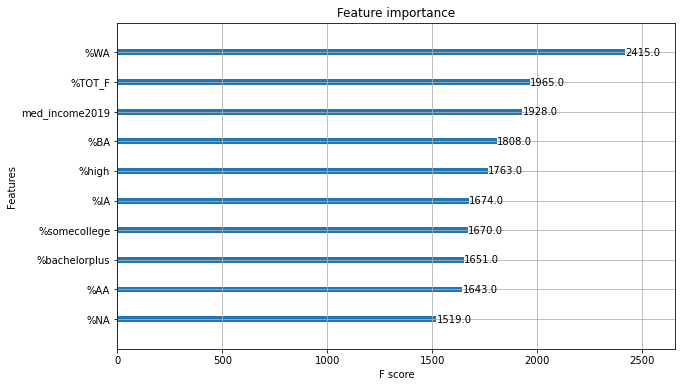

In [116]:
model = XGBRegressor(eta = 0.012825559516538222, max_depth = 5, n_estimators = 730, subsample = 0.4707177440848752, tree_method = 'hist')
model.fit(x_train_demog, y_train)
print(np.sqrt(mean_squared_error(y_test, model.predict(x_test_demog))))
rmse_results['tuned XGBoost without SCI'] = np.sqrt(mean_squared_error(y_test, model.predict(x_test_demog)))

import matplotlib.pylab as plt
from matplotlib import pyplot
from xgboost import plot_importance
plot_importance(model) 
plt.show()

In [123]:
rmse_results

{'OLS w/ 3 SCI buckets': 0.09493309653983951,
 'OLS with 2 distance buckets': 0.09490857101592567,
 'OLS with all demog predictors': 0.06854140161179204,
 'Forward Stepwise w/ 8 predictors': 0.06996915351642546,
 'Forward Stepwise w/ 7 predictors without SCI': 0.07080617020376986,
 'Lasso Regression': 0.07080617020376986,
 'GLM': 0.06902116966029863,
 'GLM without SCI': 0.07056290805588866,
 'tuned XGBoost': 0.055750325457463855,
 'tuned XGBoost without SCI': 0.05645178476638168}